In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

training_set = pd.read_csv('Dataset/fashion-mnist_train.csv')
test_set = pd.read_csv('Dataset/fashion-mnist_test.csv')

print(training_set.shape)
print(test_set.shape)

(60000, 785)
(10000, 785)


In [19]:
def data_prep(df, target):
    
    # Extract feature columns
    feature_columns = [col for col in df.columns if col != target]
    
    # Determine the type of the target column
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Convert features to float32
    X = df[feature_columns].values.astype(np.float32)
    
    # Convert target to float32
    y = df[target].values.astype(np.float32)
    
    # Handle target based on type
    if target_type in (np.int64, np.int32):
    # One hot encode for classification
        y = pd.get_dummies(df[target]).values.astype(np.float32)
    else:
    # For regression, just convert to float32
        y = df[target].values.astype(np.float32)
    return X, y

In [20]:
# X is pixels, y is labels

X_train, y_train = data_prep(training_set, 'label')
X_test, y_test = data_prep(test_set, 'label')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(y_test[0])

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


(54000, 784)
(54000, 10)
(6000, 784)
(6000, 10)


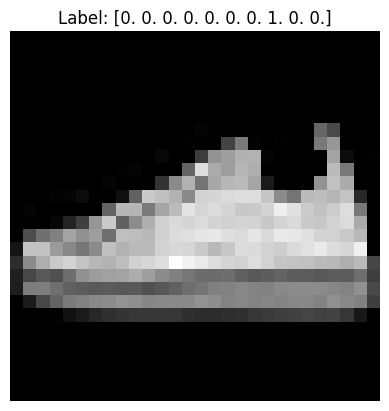

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

# choosing an image
image_array = X_train[69]
label = y_train[69]

# reshape 784 to 28x28
image_array = image_array.reshape(28, 28)

# plotting the image
plt.imshow(image_array, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [22]:
# rescaling the pixel values down to values between 0 - 1 for efficiency of neural network

X_train = X_train / 255.0
X_test = X_test / 255.0

In [23]:
class Sigmoid:
    def __init__(self):
        self.x_copy = None

    def sigmoid(self, x):
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        self.x_copy = x
        return self.sigmoid(x)

    def backward(self, dout):
        return self.sigmoid(self.x_copy) * (1 - self.sigmoid(self.x_copy)) * dout
    
class ReLU:
    def __init__(self):
        self.x_copy = None

    def forward(self, x):
        self.x_copy = x
        out = np.maximum(0, x)
        return out

    def backward(self, dout):
        #dout in: (60000, 15)
        #x_copy: (60000, 15)
        dout = dout * (self.x_copy > 0)
        #dout out: (60000, 15)
        return dout

class LeakyReLU:
    def __init__(self, alpha=0.01):
        self.alpha = alpha
        self.name = 'leaky_relu'

    def forward(self, x):
        return np.where(x > 0, x, self.alpha * x)
    
    def backward(self, x):
        return np.where(x > 0, 1, self.alpha)

class Tanh:
    def __init__(self):
        self.name = 'tanh'

    def forward(self, x):
        return np.tanh(x)
    
    def backward(self, x):
        return 1 - np.tanh(x) ** 2

In [24]:
class Softmax:
    def __init__(self, crossEntropy=False):
        self.x_copy = None
        self.cross_entropy = crossEntropy

    def softmax(self, x):
        stable_exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        y_prob = stable_exp_x / np.sum(stable_exp_x, axis=1, keepdims=True)
        return y_prob

    def forward(self, x):
        self.x_copy = x
        out = self.softmax(x)
        return out

    def backward(self, dout):
        if self.cross_entropy:
            return dout
        else:
            softmax_output = self.softmax(self.x_copy)
            return softmax_output * (dout - (dout * softmax_output).sum(axis=1, keepdims=True))

In [25]:
class Linear:
    def __init__(self, input_num, output_num, weight_init="he"):
        self.db = None
        self.dw = None
        self.rng = np.random.default_rng(42)

        if weight_init == "he":
            self.weights = self.rng.normal(size=(input_num, output_num)) * np.sqrt(2 / input_num)
        elif weight_init == "xavier":
            self.weights = self.rng.normal(size=(input_num, output_num)) * np.sqrt(1 / input_num)
        self.bias = np.zeros((1, output_num))
        self.X_copy = None

    def forward(self, X):
        self.X_copy = X
        out = np.dot(X, self.weights) + self.bias
        return out

    def backward(self, dout):
        # Gradient with respect to weights
        dw = np.dot(self.X_copy.T, dout)  # Shape: (input_num, output_num)

        # Gradient with respect to biases
        db = np.sum(dout, axis=0, keepdims=True)  # Shape: (1, output_num)

        # Gradient with respect to inputs
        dx = np.dot(dout, self.weights.T)  # Shape: (batch_size, input_num)

        self.dw = dw
        self.db = db

        return dx

    def update_weights(self, learning_rate, l2_reg=1e-4):
        assert self.dw is not None and self.db is not None, "Gradients must be computed before updating weights"
        self.weights -= learning_rate * (self.dw + l2_reg * self.weights)
        self.bias -= learning_rate * self.db

In [26]:
class CrossEntropy:
    def __init__(self, softmax=False):
        self.y_pred_copy = None
        self.softmax = softmax

    def forward(self, y, y_pred):
        self.y_pred_copy = np.clip(y_pred, 1e-15, 1-1e-15)
        loss = -np.mean(np.sum(y * np.log(self.y_pred_copy), axis=1)) # axis = 1 to sum across classes
        return loss

    def backward(self, y):
        if self.softmax:
            return self.y_pred_copy - y
        # -y / y_pred / y.shape[0]
        return np.where(y == 1, - y / (self.y_pred_copy + 1e-15) / y.shape[0], 0)
    
def decaying_lr(epoch, initial_lr=1e-2, decay_rate = 0.1):
    lr = np.clip(initial_lr / (1 + decay_rate * epoch), 1e-4, 1e-2)
    return lr

In [27]:
class InvertedDropout:
    def __init__(self, rate):
        self.dropout_rate = rate
        self.mask = None
        self.rng = np.random.default_rng(42)

    def forward(self, x, training=True):
        if training:
            init_mask = self.rng.random(x.shape)
            self.mask = (init_mask > self.dropout_rate).astype(np.float32)
            return x * self.mask / (1 - self.dropout_rate)
        else:
            return x

    def backward(self, dout):
        return dout * self.mask

In [28]:
class EarlyStopping:
  def __init__(self, patience=5, min_change=0.01):
    self.patience = patience
    self.min_change = min_change
    self.prev_loss = None
    self.penalty_count = 0

  def track(self, val_loss):
    if self.prev_loss is None:
      self.prev_loss = val_loss
      return True
    if self.prev_loss - val_loss <= self.min_change:
      self.penalty_count += 1
    else:
      self.penalty_count = 0
    self.prev_loss = val_loss
    return self.penalty_count <= self.patience

In [29]:
class BatchNorm:
    def __init__(self, num_features, epsilon=1e-5, momentum=0.9):
        self.num_features = num_features
        self.epsilon = epsilon
        self.momentum = momentum
        self.gamma = np.ones((1, num_features))
        self.beta = np.zeros((1, num_features))
        self.running_mean = np.zeros((1, num_features))
        self.running_var = np.ones((1, num_features))
        self.training = True
        # Store input for backward pass
        self.input = None

        self.gamma_momentum = np.zeros_like(self.gamma)
        self.beta_momentum = np.zeros_like(self.beta)

    def forward(self, x):
        # Store input for backward pass
        self.input = x
        
        if self.training:
            batch_mean = np.mean(x, axis=0, keepdims=True)
            batch_var = np.var(x, axis=0, keepdims=True)
            
            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var
            
            # Normalize
            x_norm = (x - batch_mean) / np.sqrt(batch_var + self.epsilon)
            
            # Store values for backward pass
            self.batch_mean = batch_mean
            self.batch_var = batch_var
            self.x_norm = x_norm
            
        else:
            # Use running statistics for inference
            x_norm = (x - self.running_mean) / np.sqrt(self.running_var + self.epsilon)
        
        # Scale and shift
        out = self.gamma * x_norm + self.beta
        return out

    def backward(self, dout):
        # Get batch size
        m = dout.shape[0]
        
        # Gradients for beta and gamma
        self.dbeta = np.sum(dout, axis=0, keepdims=True)
        self.dgamma = np.sum(dout * self.x_norm, axis=0, keepdims=True)
        
        # Gradient with respect to normalized input
        dx_norm = dout * self.gamma
        
        # Gradient with respect to variance
        dvar = np.sum(dx_norm * (self.input - self.batch_mean) * -0.5 * 
                     np.power(self.batch_var + self.epsilon, -1.5), axis=0, keepdims=True)
        
        # Gradient with respect to mean
        dmean = np.sum(dx_norm * -1 / np.sqrt(self.batch_var + self.epsilon), axis=0, keepdims=True) + \
                dvar * np.mean(-2 * (self.input - self.batch_mean), axis=0, keepdims=True)
        
        # Gradient with respect to input
        dx = dx_norm / np.sqrt(self.batch_var + self.epsilon) + \
             dvar * 2 * (self.input - self.batch_mean) / m + \
             dmean / m
             
        return dx

    def update_params(self, learning_rate, momentum=0.9):
        # Update with momentum
        self.gamma_momentum = momentum * self.gamma_momentum - learning_rate * self.dgamma
        self.beta_momentum = momentum * self.beta_momentum - learning_rate * self.dbeta
        
        self.gamma += self.gamma_momentum
        self.beta += self.beta_momentum

In [30]:
class NeuralNetwork:
    def __init__(self, layers, loss_fn):
        self.layers = layers
        self.loss_fn = loss_fn
        return

    def forward(self, x, training=True):
        for layer in self.layers:
            if isinstance(layer, InvertedDropout):
              x = layer.forward(x, training=training)
            else:
              x = layer.forward(x)
        return x

    def loss(self, y, y_pred):
        return self.loss_fn.forward(y, y_pred)

    def backward(self, y_train):
        grad = self.loss_fn.backward(y_train)
        for i in range(len(self.layers) - 1, -1, -1):
            grad = np.clip(grad, -2, 2)
            grad = self.layers[i].backward(grad)

    def update(self, epoch):
        for layer in self.layers:
            if isinstance(layer, Linear):
                layer.update_weights(decaying_lr(epoch))

    def predict(self, X):
        return self.forward(X, training=False)

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        correct_predictions = np.argmax(y_pred, axis=1) == np.argmax(y_test, axis=1)
        accuracy = np.mean(correct_predictions)
        return accuracy

    def batch_train(self, X_train, y_train, epochs=100):
        loss_hist = []
        for epoch in range(epochs):
            y_pred = self.forward(X_train)
            loss = self.loss(y_train, y_pred)
            if epoch % 5 == 0:
                print(f"Epoch: {epoch}, Loss: {loss}")
            loss_hist.append(loss)
            self.backward(y_train)
            self.update(epoch)
        return loss_hist

    def mini_batch_train(self, X_train, y_train, X_val, y_val, earlyStopping=False, epochs=100, batch=128):
      loss_hist = []
      avg_loss_hist = []
      val_loss_hist = []
      if earlyStopping:
        cb = EarlyStopping()
      for epoch in range(epochs):
        for i in range(0, len(X_train), batch):
          X_train_batch = X_train[i: i+batch]
          y_train_batch = y_train[i: i+batch]
          y_pred = self.forward(X_train_batch)
          loss = self.loss(y_train_batch, y_pred)
          loss_hist.append(loss)
          self.backward(y_train_batch)
          self.update(epoch)
        avg_loss = np.mean(loss_hist)
        avg_loss_hist.append(avg_loss)
        val_loss = self.predict_val(X_val, y_val)
        val_loss_hist.append(val_loss)
        if epoch % 5 == 0:
              print(f"Epoch: {epoch}, training loss: {avg_loss}, val loss: {val_loss}")
        criterea = cb.track(val_loss)
        if not criterea:
          print(f"Early stopping on epoch {epoch}")
          return avg_loss_hist, val_loss_hist
        loss_hist.clear()
      return avg_loss_hist, val_loss_hist

    def predict_val(self, X_val, y_val):
      y_pred = self.forward(X_val)
      loss = self.loss(y_val, y_pred)
      return loss

In [31]:
def plot_loss(loss_hist, val_loss):
    plt.plot(loss_hist, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Val Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
model = NeuralNetwork(
    [
        Linear(X_train.shape[1], 600),
        ReLU(),
        InvertedDropout(0.5),
        Linear(600, 300),
        ReLU(),
        InvertedDropout(0.5),
        Linear(300,100),
        ReLU(),
        InvertedDropout(0.3),
        # Linear(100,50),
        # ReLU(),
        InvertedDropout(0.3),
        Linear(100, 10,weight_init="xavier"),
        Softmax(crossEntropy=True)
    ],
    CrossEntropy(softmax=True))

In [ ]:
X_train_sample = X_train
y_train_sample = y_train
loss_hist, val_loss_hist = model.mini_batch_train(X_train_sample, y_train_sample, X_val, y_val, earlyStopping=True, epochs=150)
plot_loss(loss_hist, val_loss_hist)

Epoch: 0, training loss: 1.0066237202034014, val loss: 10.340173576858964
Epoch: 5, training loss: 0.45977302268421044, val loss: 7.272696175673512
Epoch: 10, training loss: 0.4019238038999724, val loss: 6.4519856953635655


In [ ]:
acc = model.evaluate(X_test, y_test)
print(acc)

y_pred = model.predict(X_test[:5])
y = y_test[:5]
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = np.argmax(y_test[:5], axis=1)
print("Predicted classes:", predicted_classes)
print("True classes:", true_classes)